# Training a model to add accent to Vietnamese text with deep learning

TL;DR: We are going to train a (somewhat) deep neural network to add accent to Vietnamese text. Its task is to add the missing accent to an input sentence, e.g. to return "cô gái đến từ hôm qua" for the input "co gai den tu hom qua". The model is a 3 layers LSTM with 1.5 militions parameters, about 5.6 MB on disk. It is trained over about 150MB of Vietnamese news article with minimal pre-processing and reach about 97% accuracy (characters wise).

First, some common import for working on data:

In [1]:
%matplotlib inline

from __future__ import print_function, division

import itertools
import os
import random
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for reproducibility
random.seed(1337)
np.random.seed(1337)

Below is some tunable configuration for the model that we are going to train. Some will make sense later on.

In [2]:
# maximum string length to train and predict
# this is set based on our ngram length break down below
MAXLEN = 32

# minimum string length to consider
MINLEN = 3

# how many words per ngram to consider in our model
NGRAM = 5

# inverting the input generally help with accuracy
INVERT = True

# mini batch size
BATCH_SIZE = 128

# number of phrases set apart from training set to validate our model
VALIDATION_SIZE = 100000

# using g2.2xl GPU is ~5x faster than a Macbook Pro Core i5 CPU
HAS_GPU = True

# Preparing Data

We need a lot of Vietnamese text to train our model, with and without accent. A simple way would be to crawl some of the common website to grab the text, remove the accent and use them as training data. Here I already crawled about 50k articles from 2 big Vietnamese news site: http://vnexpress.net/ and http://kenh14.vn/ in the `news.csv` file. Both are chosen as they are simple to write spiders for and (hopefully) cover a wide range of common Vietnamese text.

In [3]:
df = pd.read_csv('news.csv', encoding='utf-8')
print(len(df))
df.head()

49685


,text,title
0,Ngoại trưởng Mỹ John Kerry sáng nay đi bộ đến ...,Ngoại trưởng Mỹ va đầu vào cửa văn phòng thủ t...
1,Thói quen tốt nên làm sau khi ngủ dậy\n\nẢnh m...,Thói quen tốt nên làm sau khi ngủ dậy
2,Trong đó có vô số thứ đồ khó hiểu như cối xay ...,Hàng tàu giá rẻ
3,Trước thông tin đài truyền thanh phường Khuê M...,Cục Tần số: Nhiễu sóng ở đài phát thanh Đà Nẵn...
4,SHB dành 500 tỷ đồng ưu đãi doanh nghiệp bình ...,SHB dành 500 tỷ đồng ưu đãi doanh nghiệp bình ...


For our purpose, we mostly care about a continuous block of words (called `phrase` in the code).

In [4]:
def extract_phrases(text):
    """ extract phrases, i.e. group of continuous words, from text """
    return re.findall(ur'\w[\w ]+', text, re.UNICODE)


phrases = itertools.chain.from_iterable(extract_phrases(text) for text in df.text)
phrases = [p.lower().strip() for p in phrases]
[print(s) for s in phrases[:5]]
print('Number of phrases:', len(phrases))

ngoại trưởng mỹ john kerry sáng nay đi bộ đến downing street
văn phòng thủ tướng anh
để bắt đầu cuộc gặp song phương với thủ tướng theresa may
mirror cho biết
cánh cửa văn phòng được mở ra khi ngoại trưởng kerry đến nhưng ông chưa bước vào ngay mà còn quay lại chào báo giới
Number of phrases: 3607868


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06c0b949d0>]], dtype=object)

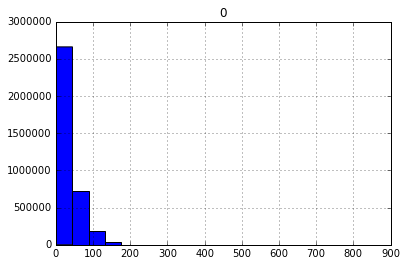

In [5]:
pd.DataFrame([len(t) for t in phrases]).hist(bins=20)

We have about 3.6 millions phrase with sized mostly in 0 - 200 characters length. That might be bit too long for a LSTM network to remember effectively so we are going to break it down to a lot of n-grams for easier processing. Also, Vietnamese accent for a word can be determined from some small surrounded words most of the time so something like a 5-gram or 7-gram model will be pretty much enough for our purpose.

So let's generate the n-gram from our text:

In [6]:
def gen_ngrams(words, n=3):
    """ gen n-grams from given phrase or list of words """
    if isinstance(words, (str, unicode)):
        words = re.split('\s+', words.strip())
    
    if len(words) < n:
        padded_words = words + ['\x00'] * (n - len(words))
        yield tuple(padded_words)
    else:
        for i in range(len(words) - n + 1):
            yield tuple(words[i: i+n])


list(gen_ngrams('co gai den tu hom qua', NGRAM))

[('co', 'gai', 'den', 'tu', 'hom'), ('gai', 'den', 'tu', 'hom', 'qua')]

In [7]:
ngrams = itertools.chain.from_iterable(gen_ngrams(p, NGRAM) for p in phrases)
ngrams = list(set(' '.join(t) for t in set(ngrams)))
[print(t) for t in ngrams[:5]]
print('Number of {}-gram: {}'.format(NGRAM, len(ngrams)))

xe cơ giới của liberty
bệnh viện việt    
mẫu thịt heo thu được
about those 62 million girls
nghĩ những người như thế
Number of 5-gram: 11249757


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f06c56b3790>]], dtype=object)

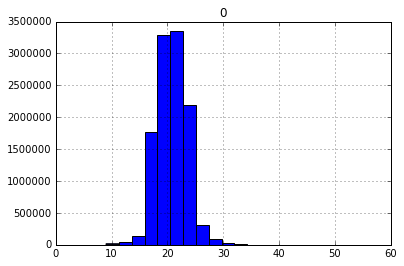

In [8]:
pd.DataFrame([len(ngram) for ngram in ngrams]).hist(bins=20)

So we have 11 milions 5-gram with length varied mostly from 15-25 characters. Sound good.

Also as mentioned above, the easiest way to get a lot of training data to add accent to Vietnamese text is to get a accented text then remove the accent:

In [9]:
accented_chars = {
    'a': u'a á à ả ã ạ â ấ ầ ẩ ẫ ậ ă ắ ằ ẳ ẵ ặ',
    'o': u'o ó ò ỏ õ ọ ô ố ồ ổ ỗ ộ ơ ớ ờ ở ỡ ợ',
    'e': u'e é è ẻ ẽ ẹ ê ế ề ể ễ ệ',
    'u': u'u ú ù ủ ũ ụ ư ứ ừ ử ữ ự',
    'i': u'i í ì ỉ ĩ ị',
    'y': u'y ý ỳ ỷ ỹ ỵ',
    'd': u'd đ',
}

plain_char_map = {}
for c, variants in accented_chars.items():
    for v in variants.split(' '):
        plain_char_map[v] = c


def remove_accent(text):
    return u''.join(plain_char_map.get(char, char) for char in text)

remove_accent(u'cô gái đến từ hôm qua')

u'co gai den tu hom qua'

Neural network does not work on text but float matrix, so we need a Codec to encode / decode our text to / from a matrix. This codec is basically just a mapping between a character and its index in our alphabet for each character in the string.

In [10]:
class CharacterCodec(object):
    def __init__(self, alphabet, maxlen):
        self.alphabet = list(sorted(set(alphabet)))
        self.index_alphabet = dict((c, i) for i, c in enumerate(self.alphabet))
        self.maxlen = maxlen

    def encode(self, C, maxlen=None):
        maxlen = maxlen if maxlen else self.maxlen
        X = np.zeros((maxlen, len(self.alphabet)))
        for i, c in enumerate(C[:maxlen]):
            X[i, self.index_alphabet[c]] = 1
        return X
    
    def try_encode(self, C, maxlen=None):
        try:
            return self.encode(C, maxlen)
        except KeyError:
            return None

    def decode(self, X, calc_argmax=True):
        if calc_argmax:
            X = X.argmax(axis=-1)
        return ''.join(self.alphabet[x] for x in X)


#\x00 is the padding characters
alphabet = set('\x00 _' + string.ascii_lowercase + string.digits + ''.join(plain_char_map.keys()))
codec = CharacterCodec(alphabet, MAXLEN)

print(codec.encode(u'cô gái đến từ hôm qua'))
print(codec.decode(codec.encode(u'cô gái đến từ hôm qua')).replace('\x00', '#'))

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
cô gái đến từ hôm qua###########


The whole training dataset doesn't fit in memory (of a EC2 g2.2xlarge instance) so instead of loading them all into memory, we are going to create a generator that will generate training data as needed.

In [11]:
np.random.shuffle(ngrams)
train_size = len(ngrams) - VALIDATION_SIZE
train_set = ngrams[:train_size]
validation_set = ngrams[train_size:]

print('train size: {}'.format(len(train_set)))
print('validation size: {}'.format(len(validation_set)))


def gen_batch(it, size):
    """ batch the input iterator to iterator of list of given size"""
    for _, group in itertools.groupby(enumerate(it), lambda x: x[0] // size):
        yield list(zip(*group))[1]


def gen_stream(ngrams):
    """ generate an infinite stream of (input, output) pair from phrases """
    while True:
        for s in ngrams:
            output_s = s + '\x00' * (MAXLEN - len(s))
            input_s = remove_accent(output_s)    
            input_s = input_s[::-1] if INVERT else input_s
            input_vec = codec.try_encode(input_s)
            output_vec = codec.try_encode(output_s)
            if input_vec is not None and output_vec is not None:
                yield input_vec, output_vec


def gen_data(ngrams, batch_size=128):
    """ generate infinite X, Y array of batch_size from given phrases """
    for batch in gen_batch(gen_stream(ngrams), size=batch_size):
        # we need to return X, Y array from one batch, which is a list of (x, y) pair
        X, Y = zip(*batch)
        yield np.array(X), np.array(Y)


next(iter(gen_data(train_set, 1)))

train size: 11149757
validation size: 100000


(array([[[ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]),
 array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.,  0.]]]))

# Building the Model

This perhaps is the simplest step in the process. Keras, http://keras.io/, makes building a NN relatively painless, especially for someone just started learning like me. Just Copy N' Paste from here and there, modified a bit, stacked them together and we can have a 3 LSTM layers network with about 1.5 milion parameters like below.

This is mostly stolen from the Keras's example on [training an RNN to perform addition on numbers](https://github.com/fchollet/keras/blob/master/examples/addition_rnn.py)! Crazy! It can learn math by itself!

In [12]:
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.models import Sequential
from keras.engine.training import slice_X
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent
from keras.callbacks import Callback


RNN = recurrent.LSTM
HIDDEN_SIZE = 256

rnn_consume_less = 'gpu' if HAS_GPU else 'cpu'

model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(alphabet)), consume_less=rnn_consume_less))
model.add(RepeatVector(MAXLEN))
model.add(RNN(HIDDEN_SIZE, return_sequences=True, consume_less=rnn_consume_less))
model.add(RNN(HIDDEN_SIZE, return_sequences=True, consume_less=rnn_consume_less))
model.add(TimeDistributed(Dense(len(alphabet))))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1 (LSTM)                    (None, 256)           371712      lstm_input_1[0][0]               
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 32, 256)       0           lstm_1[0][0]                     
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 32, 256)       525312      repeatvector_1[0][0]             
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 32, 256)       525312      lstm_2[0][0]                     
___________________________________________________________________________________________

# Training the Model

Okay, now the harder and longer part, training our model. Our training data don't even fit in memory so training will take a long time, even with GPU. We need something to keep the history so we can look at it at some point later:

In [13]:
from collections import defaultdict


class EverHistory(Callback):
    """ A Keras History that isn't cleared upon training begin and know how to plot its loss and accuracy history """
    
    def __init__(self):
        self.epoch = []
        self.history = defaultdict(list)
    
    def on_epoch_end(self, epoch, logs={}):
        self.epoch.append(len(self.epoch))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def _plot(self, name, metric):
        legend = [metric]
        plt.figure(figsize=(10, 6))
        plt.plot(self.epoch, self.history[metric], marker='.')
        
        val_metric = 'val_' + metric
        if val_metric in self.history:
            legend.append(val_metric)
            plt.plot(self.epoch, self.history[val_metric], marker='.')

        plt.title(name + ' over epochs')
        plt.xlabel('Epochs')
        plt.legend(legend, loc='best')
        plt.show()
        
    def plot_loss(self):
        self._plot('Loss', 'loss')
        
    def plot_accuracy(self):
        self._plot('Accuracy', 'acc')


history = EverHistory()

Let's train our model over a small subset of data to see if it works:

In [14]:
train_generator = gen_data(train_set, batch_size=BATCH_SIZE)
validation_generator = gen_data(validation_set, batch_size=BATCH_SIZE)

model.fit_generator(train_generator, samples_per_epoch=128000, nb_epoch=1,
                    validation_data=validation_generator, nb_val_samples=12800,
                    callbacks=[history])

Epoch 1/1
128000/128000 [==============================] - 191s - loss: 2.1010 - acc: 0.5042 - val_loss: 1.6486 - val_acc: 0.5736


So, 190 seconds for about 1/100th of our training data. This will take a *looooooong* time indeed. But hey, we are at 50% accuracy already after this very 1st epoch (technically 1/100th epoch). Let's see what our model think is a correct accent for the phrase "*co gai den tu hom qua*".

In [15]:
from collections import Counter


def guess(ngram):
    text = ' '.join(ngram)
    text += '\x00' * (MAXLEN - len(text))
    if INVERT:
        text = text[::-1]
    preds = model.predict_classes(np.array([codec.encode(text)]), verbose=0)
    return codec.decode(preds[0], calc_argmax=False).strip('\x00')


def add_accent(text):
    ngrams = list(gen_ngrams(text.lower(), n=NGRAM))
    guessed_ngrams = list(guess(ngram) for ngram in ngrams)
    candidates = [Counter() for _ in range(len(guessed_ngrams) + NGRAM - 1)]
    for nid, ngram in enumerate(guessed_ngrams):
        for wid, word in enumerate(re.split(' +', ngram)):
            candidates[nid + wid].update([word])
    output = ' '.join(c.most_common(1)[0][0] for c in candidates)
    return output


print(u'"{}"'.format(add_accent('co gai den tu hom qua')))

"tà thn nàn đà đà đàn"


`¯\_(ツ)_/¯`

Well, that's something. Let's train for awhile longer.

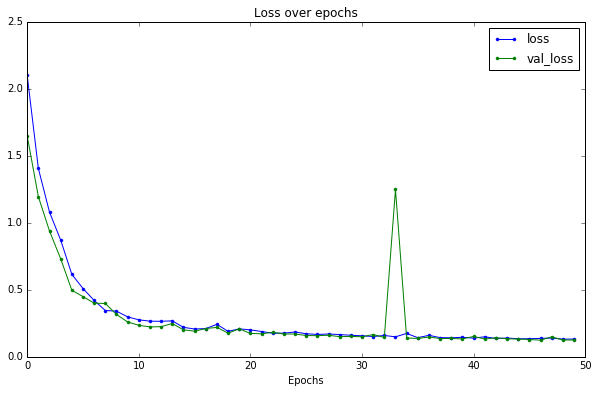

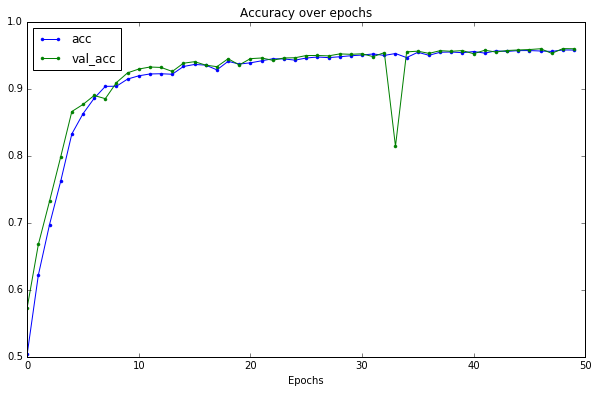

epoch  0: "tà thn nàn đà đà đàn" ❌
epoch  1: "có gài đàn có tat mui" ❌
epoch  2: "có tai đới từ hia qiệ" ❌
epoch  3: "có gii đến từ tàm qua" ❌
epoch  4: "có gii đến từ hâm qua" ❌
epoch  5: "có gồi đến từ ham qua" ❌
epoch  6: "có gái đến từ hôm qua" ❌
epoch  7: "có gái đến từ hôm qua" ❌
epoch  8: "có gái đến từ hôm qua" ❌
epoch  9: "có gái đến từ hôm quá" ❌
epoch 10: "có gái đến từ hôm quá" ❌
epoch 11: "có gái đến từ hôm qua" ❌
epoch 12: "cô gái đến từ hôm qua" ✅
epoch 13: "cô gái đến từ hôm qua" ✅
epoch 14: "có gái đến từ hôm qua" ❌
epoch 15: "cô gái đến từ hôm qua" ✅
epoch 16: "cô gái đến từ hôm qua" ✅
epoch 17: "cô gái đến từ hôm qua" ✅
epoch 18: "cô gái đến từ hôm qua" ✅
epoch 19: "cô gái đến từ hôm qua" ✅
epoch 20: "cô gái đến từ hôm qua" ✅
epoch 21: "có gái đến từ hôm qua" ❌
epoch 22: "cô gái đến từ hôm qua" ✅
epoch 23: "cô gái đến từ hôm qua" ✅
epoch 24: "cô gái đến từ hôm qua" ✅
epoch 25: "cô gái đến từ hôm qua" ✅
epoch 26: "cô gái đến từ hôm qua" ✅
epoch 27: "cô gái đến từ hôm 

In [16]:
from IPython import display


test = 'co gai den tu hom qua'
correct = u'cô gái đến từ hôm qua'
outputs = []
for i in range(50):
    display.clear_output(wait=True)
    history.plot_loss()
    history.plot_accuracy()
    outputs.append(add_accent('co gai den tu hom qua'))
    for it, out in enumerate(outputs):
        is_correct = u'✅' if out.strip('#') == correct else u'❌'
        print(u'epoch {:>2}: "{}" {}'.format(it, out, is_correct))  
    
    model.fit_generator(train_generator, samples_per_epoch=128000, nb_epoch=1,
                        validation_data=validation_generator, nb_val_samples=12800,
                        callbacks=[history])

Ding dong! We got our expected output for the first time after epoch 12 and consistently after epoch 22. Looking closer, the network got all the consonants right after 4 epochs and all the base vowels right after the 6th epoch. Our accuracy improved rapidly and stablized at about 95% and this is just about half of our training set. So let's see what happen if we train the network for some more time. This was the point when I went to sleep, then ate, then perhaps sleep again.

In [17]:
history2 = EverHistory()

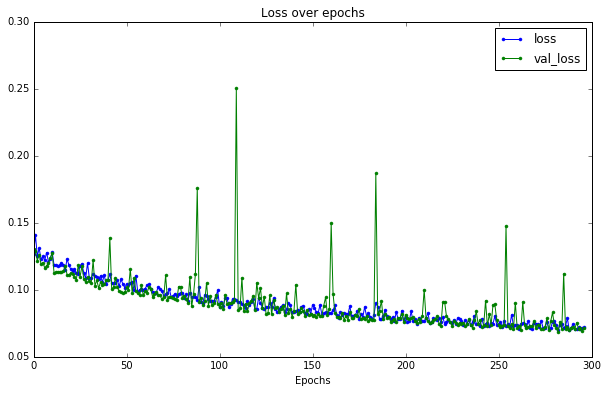

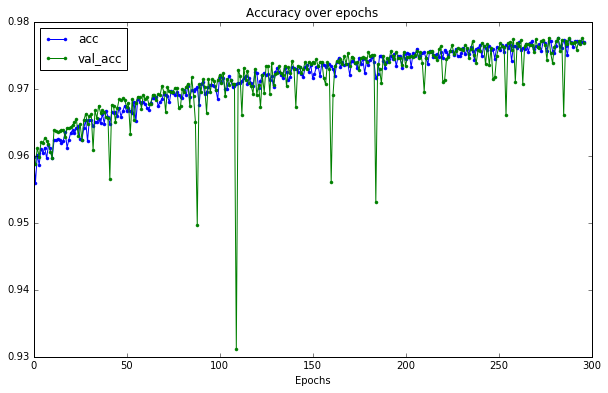

Epoch 1/1
128000/128000 [==============================] - 187s - loss: 0.0728 - acc: 0.9767 - val_loss: 0.0810 - val_acc: 0.9736


In [18]:
for i in range(5):
    display.clear_output(wait=True)
    history2.plot_loss()
    history2.plot_accuracy()
    model.fit_generator(train_generator, samples_per_epoch=128000, nb_epoch=1,
                        validation_data=validation_generator, nb_val_samples=12800,
                        callbacks=[history, history2])

So after about 300 more epochs, or 16 hours or so, we got to 97% accuracy and reduced loss to 0.07. I stopped training here as it is unlikely that the accuracy will improve any significant amount any time soon.

We can see how well the model work on this exciting news:

In [19]:
[print(add_accent(remove_accent(x))) for x in [
    'phó thủ tướng rà soát việc cho formosa thuê đất 70 năm',
    'đối với các dự án đang tồn tại và hoạt động trên lãnh thổ việt nam'.lower(),
    'không riêng Formosa',
    'sẽ có kế hoạch kiểm tra',
    'rà soát',
    'đánh giá lại theo tinh thần sai phạm là phải xử lý'
]]

phó thủ tướng rà soát việc cho formosa thuê đạt 70 năm
đối với các dự án đang tồn tại và hoạt động trên lãnh thổ việt nam
không riêng formosa   
sẽ có kế hoạch kiểm tra
rà soát     
đánh gia lại theo tinh thần sai phạm là phải xử lý


[None, None, None, None, None, None]

Unfortunately, it doesn't work as well on different kind of text, for example, story. The following text is taken from "Cho tôi xin một vé đi tuổi thơ". It looks like the kind of Vietnamese used in Vnexpress or Kenh14 is very different from Nguyễn Nhật Ánh's language.

In [20]:
[print(add_accent(remove_accent(x))) for x in [
        'cho tôi xin một vé đi tuổi thơ',
        'tóm lại là đã hết một ngày',
        'một ngày',
        'tôi chợt nhận thấy cuộc sống thật là buồn chán và tẻ nhạt',
        'năm đó tôi 8 tuổi'
    ]]

cho tôi xin một về đi tuổi thơ
tôm lại là đã hết một ngày
một ngày     
tôi chợt nhận thấy cuộc sống thật là buồn chân và tế nhất
năm do tới 8 tuổi


[None, None, None, None, None]

In [21]:
model.save_weights('weights.h5', overwrite=True)

In [22]:
!ls -lh weights.h5

-rw-r--r-- 1 lebinh lebinh 5.6M Jul 31 09:25 weights.h5
